In [1]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
#for gpu in gpus: 
#    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#загрузим модели
localizator = tf.keras.models.load_model('bounding_box_for_many_objects.h5')

In [4]:
def visualize(in_image, cords):
    big_image = tf.image.resize(in_image, (128,128)).numpy() / 256
    thickness = 1#толщина
    for i in range(len(cords)):
            #введем цвет
            color = (0, 0, 0)
            big_image = cv2.rectangle(big_image ,(int(cords[i][0])*2, int(cords[i][1])*2),(int(cords[i][2])*2,int(cords[i][3])*2),color,1)
    return big_image

In [1]:
#функция работы с нейросетями: подготовка изображения, детекция
def Detect_objects(img):
    img = tf.cast(img, tf.float32)/256#приводим тензор к новому типу
    img = tf.image.resize(img,(64,64))
    big_image = tf.image.resize(img, (128, 128))
    image_exp = tf.expand_dims(img, axis = 0)#добавляем внешнее измерение 
    #локализация
    bb_cords = localizator(image_exp)
    bb_cords = tf.squeeze(bb_cords, axis = 0)#удаляем внешнее измерение
    #нормализация по размеру картинки
    bb_cords = (bb_cords+1)/2*64
    bb_cords = tf.reshape(bb_cords, [2, 4])
    #разделяем на элементы
    fxmin, ymin, fxmax, ymax = tf.split(bb_cords, 4, axis = 1)
    #нормализуем
    xmin = tf.minimum(fxmin, fxmax)
    xmax = tf.maximum(fxmin, fxmax)
    ymin = tf.minimum(ymin, ymax)
    ymax = tf.maximum(ymin, ymax)
    xmin = tf.clip_by_value(xmin, 0, 64)#обрезаем значения тензора до заданных минимальных и максимальных значений
    ymin = tf.clip_by_value(ymin, 0, 64)
    size = xmax - xmin
    #сумма координаты и размера должны быть <= 64
    xsize = tf.clip_by_value(size, 1, 64 - xmin)
    ysize = tf.clip_by_value(size, 1, 64 - ymin)
    #нарезаем и собираем в массив 
    ymin*= 2
    xmin*= 2
    ysize*= 2
    xsize*= 2
    for n in range(2):
        ii = tf.image.crop_to_bounding_box(big_image, int(ymin[n][0]), int(xmin[n][0]), int(ysize[n][0]), int(xsize[n][0]))
        ii = tf.image.resize(ii, (32,32))
        ii = tf.expand_dims(ii, axis = 0)
        if n == 0:
            cropped = ii 
        else:
            cropped = tf.concat([cropped, ii], axis = 0)#объединяем тензоры по одному измерению
    #собираем координаты в нормальный вид
    cords = tf.concat([xmin/2, ymin/2, xmin/2+xsize/2, ymin/2+ysize/2], axis = 1)
    cords = cords.numpy()
    print(cords)
    return cords
    
    

[[19.273998 28.579239 30.24466  39.5499  ]
 [34.856033 27.75364  45.07229  37.969894]]


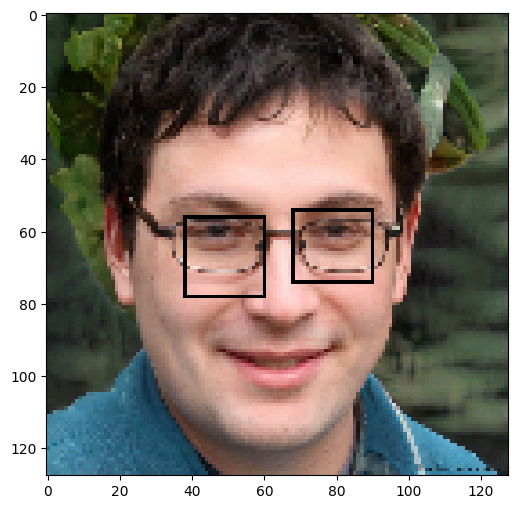

In [6]:
import os
import cv2
img_path = cv2.imread('test/1.jpg')
img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
cords = Detect_objects(img)
result = visualize(img, cords)
plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)#создание рисунка и набора вложенных графиков:Количество строк / столбцов сетки вложенных графиков 
plt.imshow(result)
plt.show()

In [ ]:
import os
os.chdir("neural/test/") #смена директории
#print("Текущая деректория:", os.getcwd())# вывести текущую директорию
p = os.listdir()
#Помещаю в папку тестовые картинки глаз людей, обрезанные по координатам
from PIL import Image
for i in range(0, 302):
    img = cv2.imread(p[i])
    im = Image.open(p[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cords = Detect_objects(img)
    im_crop_1 = im.crop((cords[0][0]*16, cords[0][1]*16, cords[0][2]*16, cords[0][3]*16))
    im_crop_2 = im.crop((cords[1][0]*16, cords[1][1]*16, cords[1][2]*16, cords[1][3]*16))
    os.chdir("neural/test/test_eye") #смена директории
    im_crop_1.save(str(p[i]) +'_1.jpg', quality=95)
    im_crop_2.save(str(p[i]) +'_2.jpg', quality=95)
    os.chdir("neural/test/") #смена директории

In [28]:
import os #Записала все названия тестовых картинок глаз людей в текстовый файл
os.chdir("neural/test/test_eye") #смена директории
path =  "neural/test/test_eye"
print('Всего каталогов: ',len(os.listdir(path)))
with open('eye_test.txt','w') as file:
    for i in os.listdir(path):
        file.write(i+'\n')

Всего каталогов:  605


In [ ]:
import os
# вывести текущую директорию
#print("Текущая деректория:", os.getcwd())
os.chdir("neural/classifications") #смена директории
#print("Все папки и файлы:", os.listdir())
p = os.listdir()
'''for i in range(595, 596):
    print (p[i])
    os.rename(p[i], str(i)+".jpg")#переименовали все файлы
    print(p[i])'''
#print(p)

In [ ]:
#Помещаю в папку картинки глаз людей, обрезанные по координатам
from PIL import Image
for i in range(595):
    img = cv2.imread(p[i])
    im = Image.open(p[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cords = Detect_objects(img)
    im_crop_1 = im.crop((cords[0][0]*16, cords[0][1]*16, cords[0][2]*16, cords[0][3]*16))
    im_crop_2 = im.crop((cords[1][0]*16, cords[1][1]*16, cords[1][2]*16, cords[1][3]*16))
    os.chdir("neural/classifications/eye") #смена директории
    im_crop_1.save(str(p[i]) +'_1.jpg', quality=95)
    im_crop_2.save(str(p[i]) +'_2.jpg', quality=95)
    os.chdir("neural/classifications") #смена директории

In [ ]:
"""import os
import cv2
directory = "neural/test"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        img_path = cv2.imread(f)
        img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
        cords = Detect_objects(img)
        result = visualize(img, cords)
        plt.figure(figsize=(10, 6))
        ax = plt.subplot(1,1,1)
        plt.imshow(result)
        plt.show()"""

In [32]:
import os #Записала все названия картинок глаз людей в текстовый файл
os.chdir("neural/classifications/eye") #смена директории
path =  "neural/classifications/eye"
print('Всего каталогов: ',len(os.listdir(path)))
with open('eye.txt','w') as file:
    for i in os.listdir(path):
        file.write(i+'\n')

Всего каталогов:  2382


In [62]:
#Записываю классы глаз в текстовый документ
# получим объект файла
file1 = open("classes.txt", "r")
# считываем все строки
lines = file1.readlines()
file2 = open('eye.txt','w')
# итерация по строкам
for i in range(1, 595):
        file2.write(str(lines[i]))
        file2.write(str(lines[i]))
# закрываем файл
file1.close

<function TextIOWrapper.close()>